# Teoria Moderna de Portfolio 

## Importando bibliotecas

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sn
from math import sqrt
from pandas_datareader import data as dt

In [2]:
import datetime

## Base de dados

Para a construção da base de dados são usados os preços de fechamento das 82 ações que compõem o índide BOVESPA, no período de 01 de Janeiro de 2018 até 01 de Julho de 2021. Os dados são obtidos no Yahoo Finance.

In [3]:
# Definindo o dataframe de dados de preço de ativos do portfólio:
precos = pd.DataFrame()

# Definindo o período a ser utilizado
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 7, 1)

# Definindo os ativos a serem utilizados (Indice BOVESPA):
stocks = ["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"]

for i in stocks:
    precos[i] = dt.get_data_yahoo(i, start = start, end = end)['Close']
    
precos.dropna(inplace=True)

#Calculando o retorno diário de cada ativo:
rets = precos.pct_change()

df = precos

In [4]:
df = precos

In [5]:
precos.tail()

,ABEV3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,BRAP4.SA,...,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-25,16.950001,45.970001,16.690001,32.900002,22.469999,26.389999,23.92,9.71,29.567499,73.070000,...,34.599998,58.410000,37.700001,36.860001,18.990000,18.840000,112.400002,42.930000,33.560001,34.009998
2021-06-28,17.500000,45.330002,16.990000,32.650002,22.299999,26.260000,24.10,9.61,30.490000,72.709999,...,35.040001,59.599998,37.830002,37.610001,19.190001,18.930000,110.599998,43.099998,34.000000,34.029999
2021-06-29,17.290001,44.529999,17.040001,32.430000,22.110001,26.100000,23.74,9.45,30.674999,74.629997,...,35.419998,60.259998,37.330002,37.400002,18.530001,19.150000,112.510002,42.419998,34.700001,33.389999
2021-06-30,17.070000,43.889999,16.820000,32.130001,21.860001,25.730000,23.10,9.37,30.514999,74.330002,...,34.660000,59.810001,36.900002,37.650002,18.389999,19.100000,113.250000,42.000000,33.689999,32.840000
2021-07-01,17.200001,43.959999,16.320000,31.790001,21.639999,25.410000,23.23,9.33,30.090000,74.129997,...,34.230000,60.330002,36.650002,36.459999,18.180000,19.290001,111.279999,41.619999,34.250000,32.400002


## Simulação dos portfólios 

1. Primeiro calculamos o retorno de cada ação utilizando o preço de fechamento;
2. Calculamos a matriz de covariância; 
3. Calcumos a média dos retornos;
4. Então, calculamos a matriz de covariância dos retornos; 
5. Por fim, a taxa livre de risco.

In [7]:
returns = df.pct_change() 
covMatrix = returns.cov()
mean_returns = returns.mean()
sigma = returns.cov()
risk_free_rate = (1 + 0.0575)**(1/252)-1

In [8]:
noofport = 1000000
weight = np.zeros((noofport,len(precos.columns)))
expectedreturn = np.zeros((noofport))
expectedvol = np.zeros((noofport))
sharpeRatio = np.zeros((noofport))

for k in range(noofport):
    w = np.array(np.random.random(len(precos.columns)))
    w = w/np.sum(w)
    weight[k,:] = w
    expectedreturn[k] = np.sum(mean_returns * w)
    expectedvol[k] = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    sharpeRatio[k] = expectedreturn[k]/expectedvol[k]

In [9]:
index = np.where(sharpeRatio == sharpeRatio.max())

In [10]:
sharpeRatio

array([0.02859727, 0.02453583, 0.02565737, ..., 0.02426845, 0.02341049,
       0.02963374])

In [11]:
import matplotlib.pyplot as plt

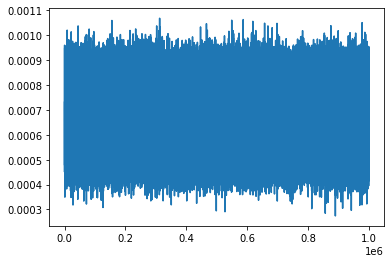

In [12]:
plt.plot(expectedreturn)

In [13]:
maxindex = np.where(sharpeRatio == sharpeRatio.max())
maxindex

(array([549286]),)

In [14]:
weight[maxindex,:]

array([[[0.0183369 , 0.01364954, 0.00502047, 0.00519666, 0.00344174,
         0.00523387, 0.00344193, 0.0093619 , 0.01479438, 0.01370203,
         0.00486843, 0.0173251 , 0.01495564, 0.01950483, 0.00991921,
         0.01549815, 0.01027347, 0.00700399, 0.00795045, 0.00095248,
         0.00885026, 0.0220639 , 0.02281803, 0.00793987, 0.00532847,
         0.00607291, 0.00871343, 0.00247172, 0.00811947, 0.021827  ,
         0.0065294 , 0.02189729, 0.01269607, 0.00579396, 0.01542856,
         0.02036883, 0.02021645, 0.02342934, 0.01777223, 0.02197732,
         0.00941316, 0.01152412, 0.01765218, 0.02244725, 0.00877472,
         0.00575782, 0.00302142, 0.00651217, 0.02576166, 0.02609115,
         0.00562064, 0.00750846, 0.00027113, 0.00346289, 0.02526686,
         0.00724858, 0.00220904, 0.02212506, 0.01894026, 0.01432371,
         0.0090717 , 0.02512637, 0.00228468, 0.02439859, 0.01089511,
         0.02225059, 0.00272244, 0.00125654, 0.00841813, 0.02448371,
         0.00505821, 0.0245982 , 0

## Plot dos resultados dos portfólios simulados

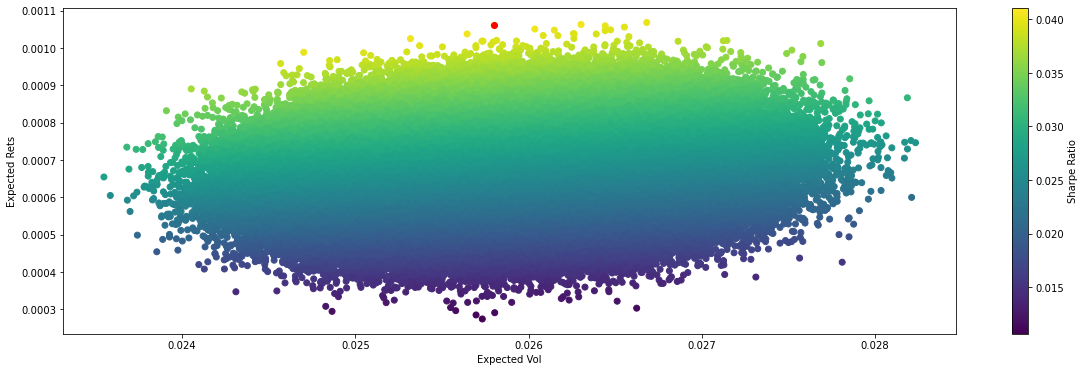

In [15]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.show()

## Fronteira de otimização

In [16]:
import scipy

In [17]:
from scipy.optimize import minimize

def negativeSR(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    SR = R/V
    return -1*SR

def checksumtoone(w):
    return np.sum(w)-1
w0 = np.full((len(precos.columns)), 1/len(precos.columns)) #chute pesos (tudo igual)

# Limitando para não ficar short (pesos entre 0 e 1)
a = [(0,1)]
for i in range (2,(len(precos.columns))+1):
    a.append((0,1))
a = tuple(a) 

bounds = (a)
constraints = ({'type':'eq','fun':checksumtoone})
w_opt = minimize(negativeSR,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
w_opt

     fun: -0.107666894374264
     jac: array([ 4.67352774e-02,  9.28172562e-02,  5.00088725e-02,  9.40020392e-02,
        7.19451793e-02,  6.96235131e-02,  6.98247254e-02,  6.53746799e-02,
        1.59861268e-02,  5.61155379e-04,  5.09895440e-02,  6.53392132e-02,
        7.83928670e-04,  9.56393695e-02,  7.83763919e-02,  1.21644977e-01,
        4.63509178e-02,  1.40581731e-01,  5.58892824e-02,  5.56773189e-02,
        3.40612466e-02,  2.58119041e-02, -4.57413495e-04,  8.66829157e-02,
        8.52188114e-02,  7.83397593e-02,  4.77552125e-02,  3.72212809e-02,
        3.72689953e-02,  5.36666047e-02,  4.70986608e-02,  2.82109343e-03,
        4.79689538e-02,  2.75576729e-02,  9.25749196e-02,  5.20330314e-02,
        3.68481241e-02,  3.27641880e-02,  3.89875574e-02,  1.06987274e-01,
        3.30019770e-02,  4.09516031e-02,  4.55219168e-02,  6.65781321e-02,
        1.71181903e-01,  5.92869734e-02,  5.79208303e-02,  3.93703496e-02,
        4.30865875e-02,  9.65166185e-03,  6.93257283e-02,  4.

In [18]:
w_opt.x

array([1.05169242e-16, 8.35196060e-18, 7.58694077e-17, 2.78395927e-16,
       0.00000000e+00, 1.28834702e-16, 1.30308697e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.12778953e-17, 4.14255378e-17, 1.42194290e-17,
       0.00000000e+00, 2.50880453e-17, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.27165870e-01, 5.97378637e-17,
       1.05442010e-16, 5.61632724e-17, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.26202501e-17, 0.00000000e+00, 2.53542627e-17,
       5.33652228e-17, 0.00000000e+00, 6.50165538e-17, 3.52002519e-17,
       0.00000000e+00, 4.70331730e-18, 1.15973543e-18, 5.02406432e-17,
       5.32457363e-17, 0.00000000e+00, 0.00000000e+00, 2.82065416e-17,
       0.00000000e+00, 0.00000000e+00, 2.86620354e-17, 0.00000000e+00,
       1.05699976e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.51323886e-17, 2.09382216e-17,
      

In [19]:
returns = np.linspace(0.,0.002,500)
volatility_opt = []
opt = []

def minimizevol(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    return V
def getreturn(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    return R
for R in returns:
    constraints = ({'type':'eq','fun':checksumtoone},
                  {"type":'eq','fun': lambda w: getreturn(w) - R})
    opt = minimize(minimizevol,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
    volatility_opt.append(opt['fun'])

In [20]:
opt

     fun: 0.019774450009560504
     jac: array([0.01499817, 0.03728783, 0.02020509, 0.0214342 , 0.01946273,
       0.01935535, 0.01121457, 0.01780874, 0.02557616, 0.02193737,
       0.02002251, 0.0199853 , 0.03037685, 0.02112724, 0.02227188,
       0.02124419, 0.01955503, 0.02501641, 0.01440431, 0.01938737,
       0.01228198, 0.02139892, 0.03469265, 0.03052408, 0.02751659,
       0.02365178, 0.01157565, 0.02505594, 0.02177706, 0.02412188,
       0.01343678, 0.01834028, 0.01568232, 0.01443442, 0.02396703,
       0.01470908, 0.02801238, 0.0222401 , 0.02933938, 0.03613872,
       0.0199579 , 0.02291539, 0.01735819, 0.02064925, 0.01949967,
       0.01516286, 0.0155144 , 0.02054539, 0.02213059, 0.01593115,
       0.02198747, 0.02753612, 0.01968787, 0.02461461, 0.02460187,
       0.02137117, 0.02013612, 0.02418654, 0.0219971 , 0.02927362,
       0.0284385 , 0.04249054, 0.01990541, 0.01146793, 0.02115068,
       0.02540499, 0.01760884, 0.01896061, 0.02028481, 0.01670086,
       0.00985387, 0.

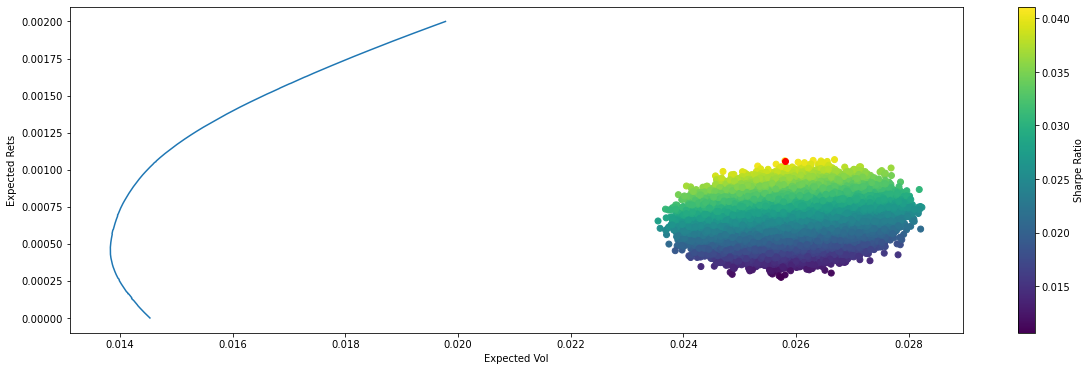

In [22]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.plot(volatility_opt,returns,'-')
plt.show()

In [23]:
df = pd.DataFrame({'Ativos':["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"], 'Peso otimo':w_opt.x})

In [24]:
df.sort_values(by = 'Peso otimo', ascending = False)

,Ativos,Peso otimo
22,CSNA3.SA,0.358349
69,SUZB3.SA,0.178010
71,TOTS3.SA,0.083914
58,PCAR3.SA,0.066617
54,MRFG3.SA,0.055939
...,...,...
1,AZUL4.SA,0.000000
40,HAPV3.SA,0.000000
41,HGTX3.SA,0.000000
42,HYPE3.SA,0.000000


In [26]:
ndf = df.nlargest(10, 'Peso otimo')


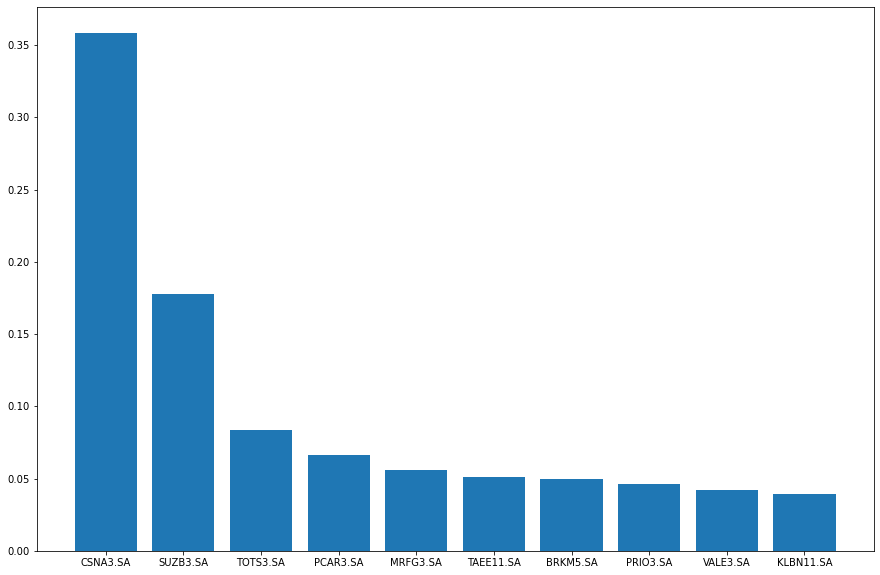

In [27]:
x_pos = np.arange(len(ndf["Ativos"]))

plt.figure(figsize=(15,10))

plt.bar(ndf["Ativos"],ndf['Peso otimo'])

# Adicionando o ticker dos ativos
plt.xticks(x_pos, ndf["Ativos"])

# Show graph
plt.show()